In [1]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

Загружаем данные, выделяем целевую переменную

In [2]:
data = pd.read_csv(load_boston()['filename'], skiprows=1)
target = data['MEDV']
del data['MEDV']

Создаем функцию для оценки качества модели

In [3]:
def get_score(data, target):
    results = []
    
    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=seed) 
        model = LinearRegression().fit(X_train, y_train)
        results.append(model.score(X_test, y_test))
        
    return np.mean(results)

Смотрим описание данных, чтобы найти пропуски:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


Пропусков нет, проверяем на выбросы, строим диаграмму размаха(ящик с усами) для каждой колонки (категориальных переменных все равно нет)

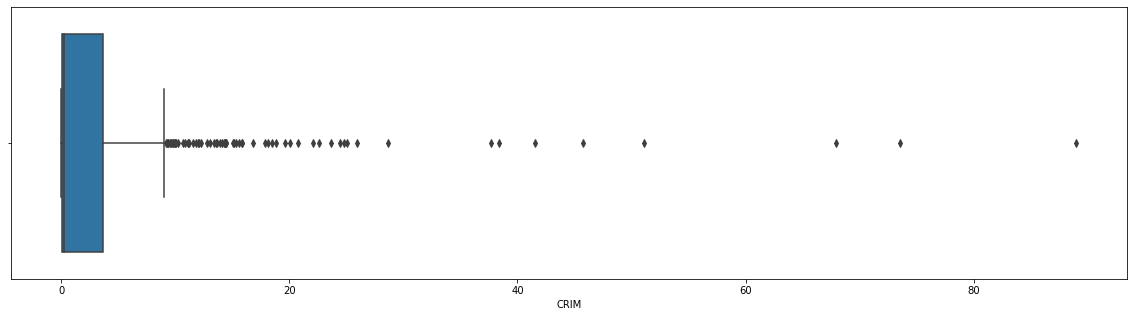

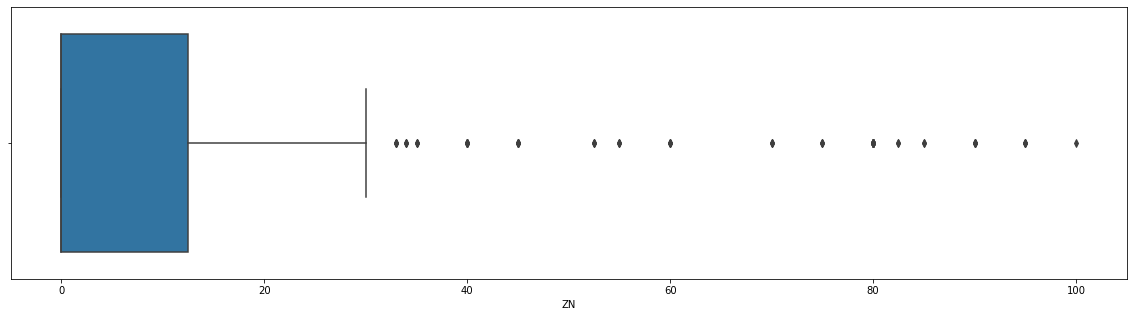

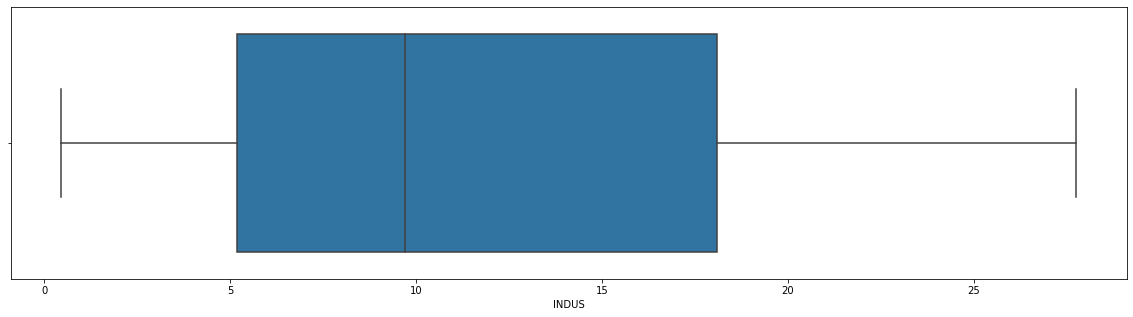

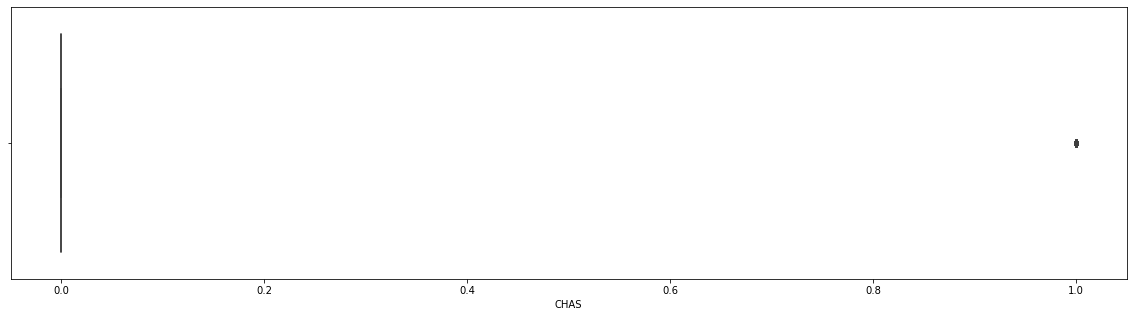

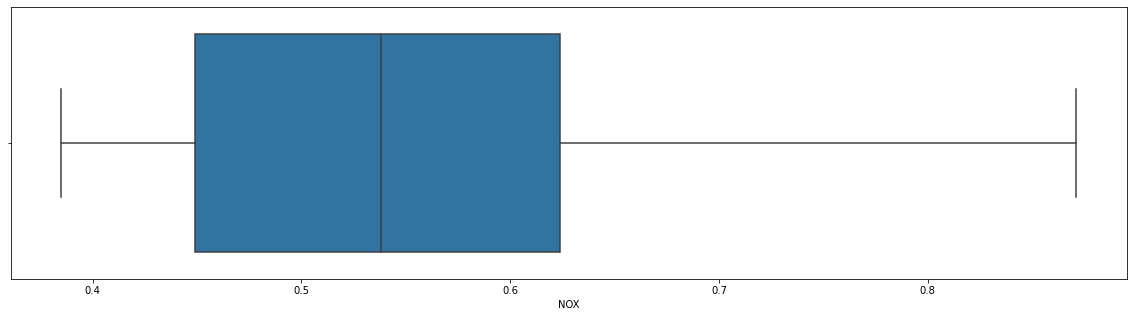

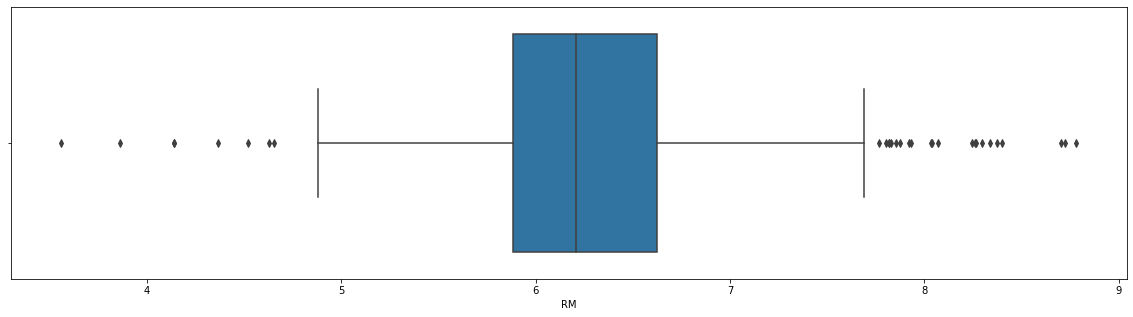

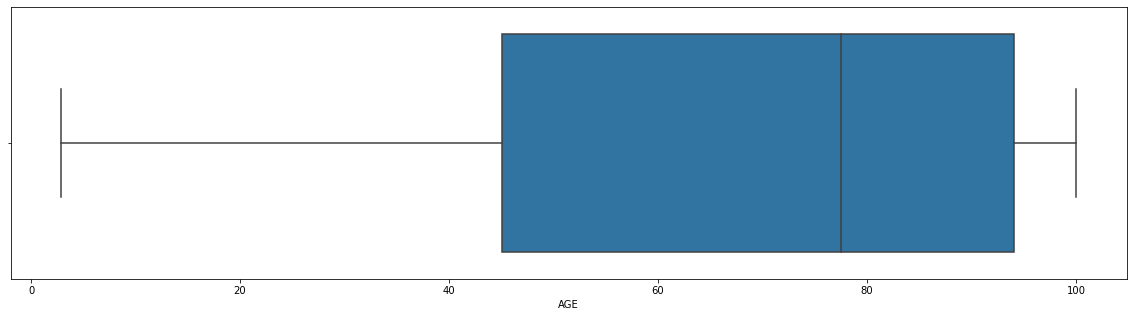

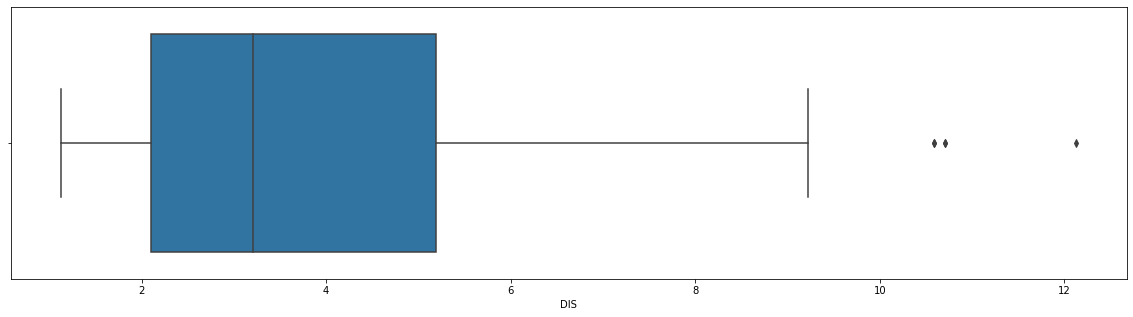

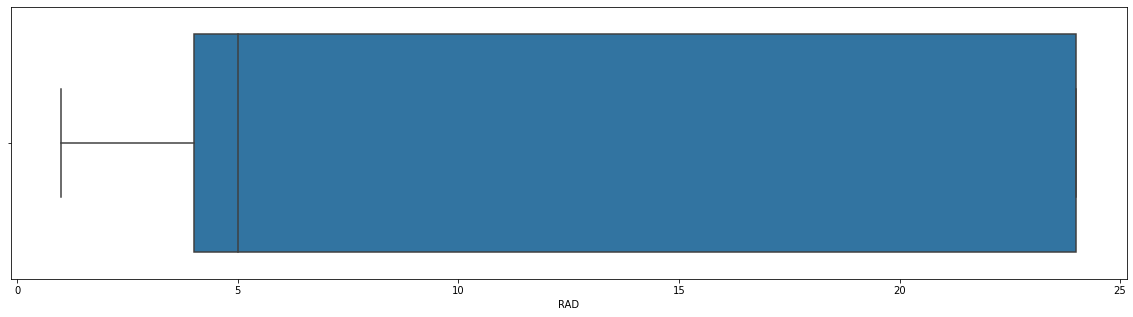

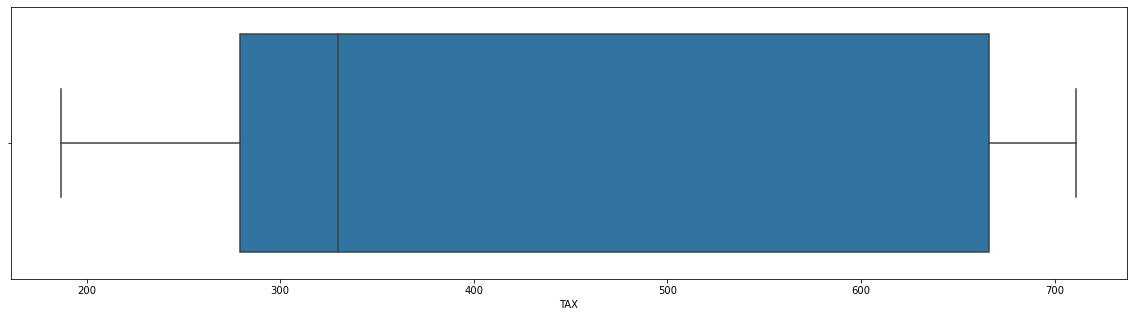

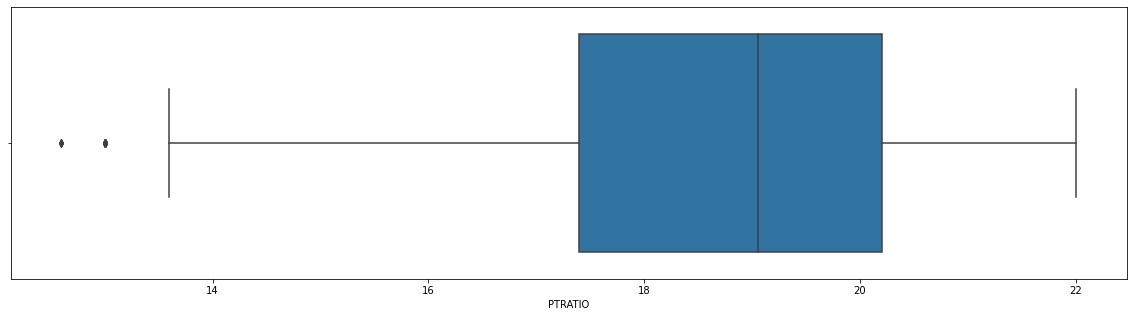

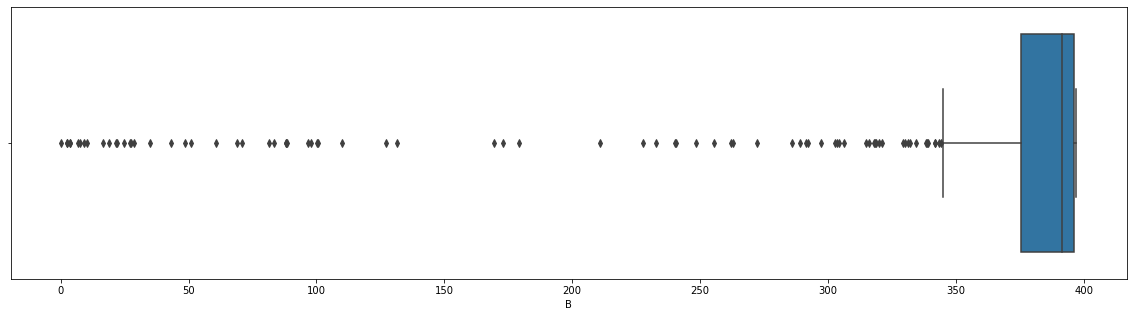

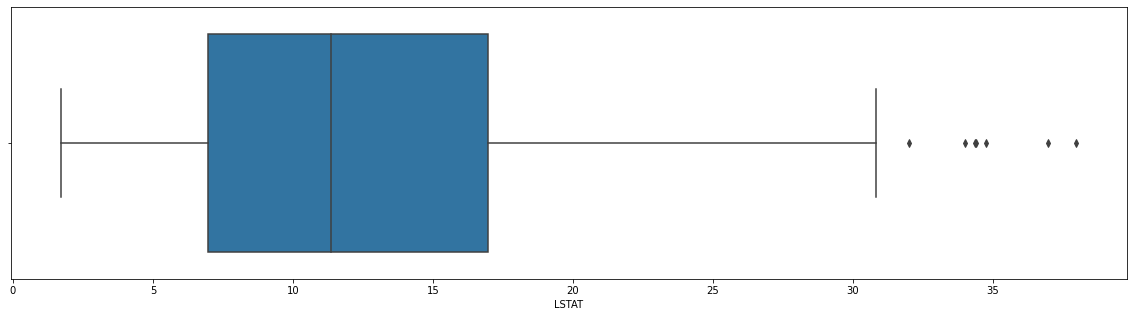

In [5]:
for column in data.columns:
    plt.figure()
    sns.boxplot(data[column])

Явных выбросов не обнаружено, вычисляем эффективность модели на сырых данных:

In [6]:
start_score = get_score(data, target)
print(start_score)

0.7134390581785317


## Мы можем сделать следующее:
* Кластеризовать данные.
* Добавить новые переменные
* Нормализовать данные
* Удалить переменные

### Проводим кластеризацию:

In [7]:
best_score = get_score(data, target)
best_n_clusters = 0
best_seed = 0

for n_clusters in range(2, 11):
    result = []
    for seed in range(0, 10):
        df = data.copy()      
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed).fit(df)
        df['cluster'] = kmeans.predict(df)
        
        result.append(get_score(df, target))
        
    score = np.mean(result)
    if score > best_score :
        best_score = score
        best_n_clusters = n_clusters
        best_seed = seed

print(best_score - get_score(data, target))
print(best_n_clusters)
print(best_seed)

0.001882237311649937
6
9


Смысл в кластеризации есть, кластеризуем данные

In [8]:
kmeans = KMeans(n_clusters=6, random_state=9).fit(data)
data['cluster'] = kmeans.predict(data)

### Добавляем переменные

Предполагаю, что добавление следующих переменных может помочь:
* ZN / INDUS = соотношение жилья и производства
* ZN * AGE = процент старых домой с проживающими собственниками 
* RAD / PTRATIO = отношение индекса доступности железных дорог к соотношению ребенок/учитель. Чем меньше учителей на ребенка, тем больше вероятность, что он будет учиться за городом, и большее число повзрослевших детей ездит в университет
* CHAS * NOX = Предполагаем, что при нахождении рядом с рекой, экология(загрязнение воздуха), может беспокоить больше/меньше
* DIS / RAD = Отношения расстояния до центра занятости к индексу доступности железных дорог (насколько легко это расстояние до центров занятости преодолевать)
* sqrt(B/1000) + 0.63 = Процент афроамериканцев (расизм в штатах все еще весьма актуальный фактор)
* TAX * LSTAT = Налоговая нагрузка с учетом процента бедного населения

In [9]:
initial_score = get_score(data, target)

df = data.copy()
df['ZN / INDUS'] = df['ZN'] / df['INDUS']
print('ZN / INDUS', get_score(df, target) - initial_score)

df = data.copy()
df['ZN * AGE'] = df['ZN'] * df['AGE']
print('ZN * AGE', get_score(df, target) - initial_score)

df = data.copy()
df['RAD / PTRATIO'] = df['RAD'] / df['PTRATIO']
print('RAD / PTRATIO', get_score(df, target) - initial_score)

df = data.copy()
df['CHAS * NOX'] = df['CHAS'] * df['NOX']
print('CHAS * NOX', get_score(df, target) - initial_score)

df = data.copy()
df['DIS / RAD'] = df['DIS'] / df['RAD']
print('DIS / RAD', get_score(df, target) - initial_score)

df = data.copy()
df['sqrt(B/1000) + 0.63'] = np.sqrt(df['B']/1000) + 0.63
print('sqrt(B/1000) + 0.63', get_score(df, target) - initial_score)

df = data.copy()
df['TAX * LSTAT'] = df['TAX'] * df['LSTAT']
print('TAX * LSTAT', get_score(df, target) - initial_score)

ZN / INDUS 0.004113337836739395
ZN * AGE -4.1612264400359145e-05
RAD / PTRATIO -0.0010167255039553735
CHAS * NOX -0.00035800365708349435
DIS / RAD -0.0006176468922022282
sqrt(B/1000) + 0.63 0.001064863732688881
TAX * LSTAT -0.002930385186567408


Соотношение жилья и производства, как и процент афроамериканцев, улучшат качесто модели.

In [10]:
data['ZN / INDUS'] = data['ZN'] / data['INDUS']
data['sqrt(B/1000) + 0.63'] = np.sqrt(data['B']/1000) + 0.63

Попробуем построить гистрограмму для каждой переменной, 
Возможно бы увидим переменные, подходящие для создания индикаторных переменных

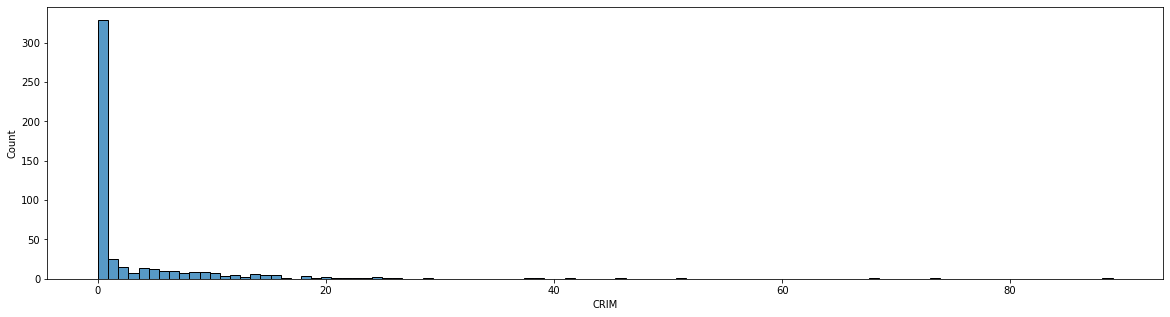

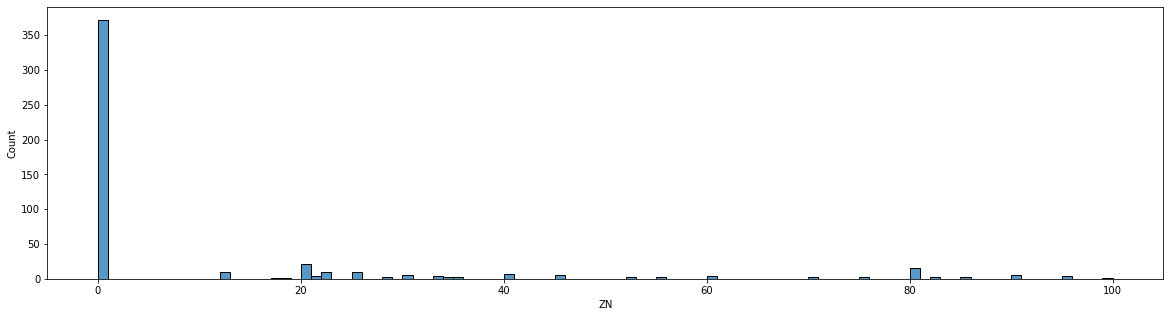

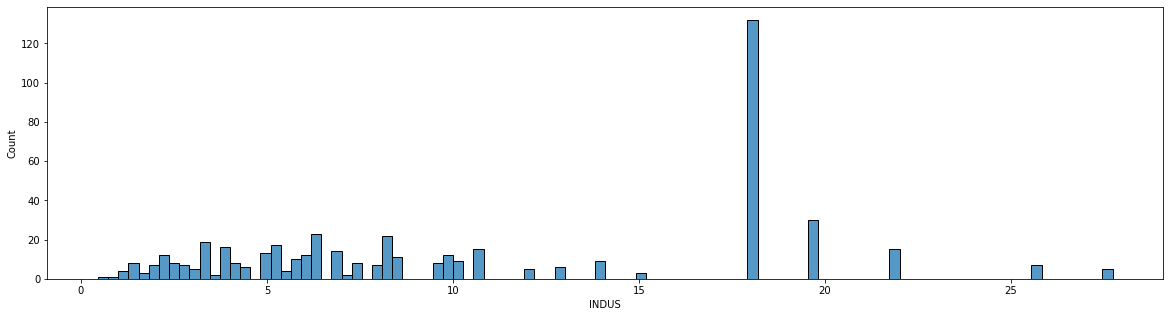

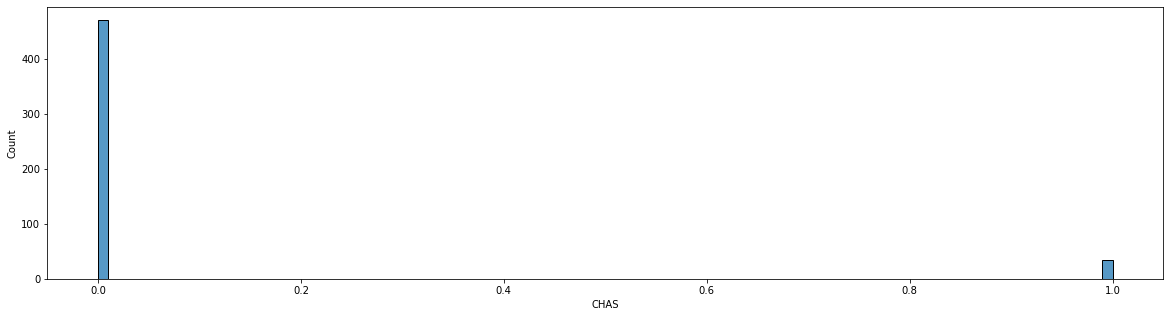

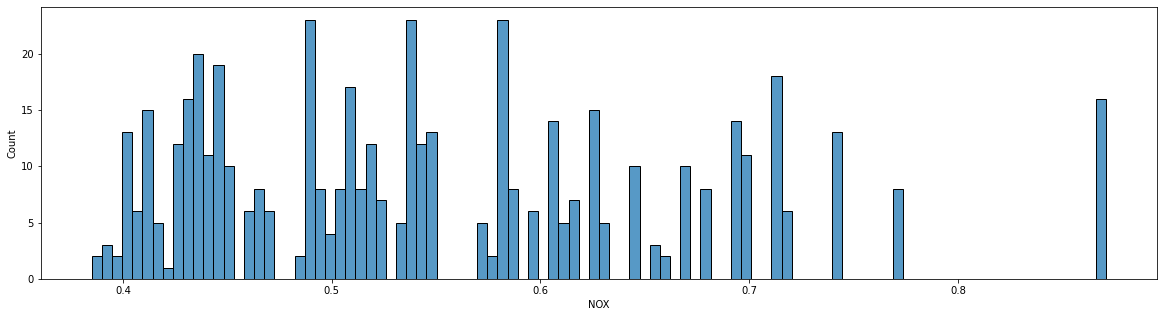

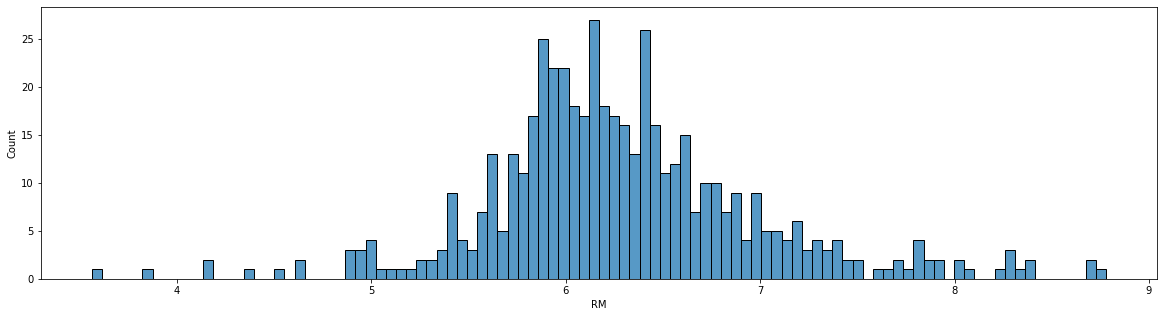

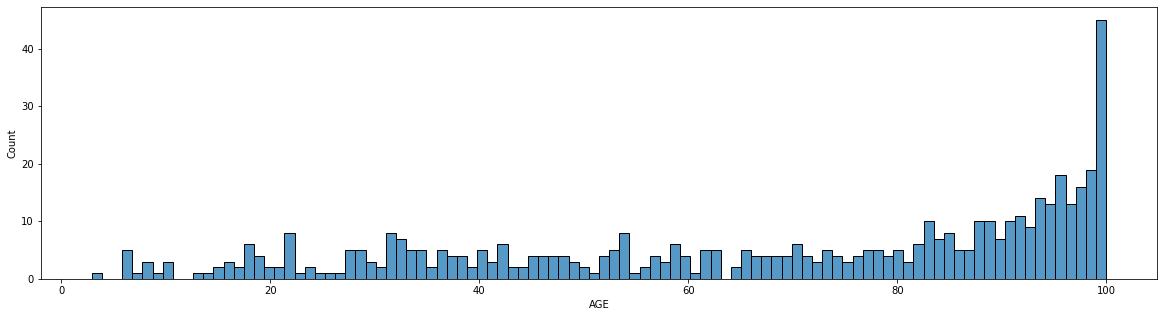

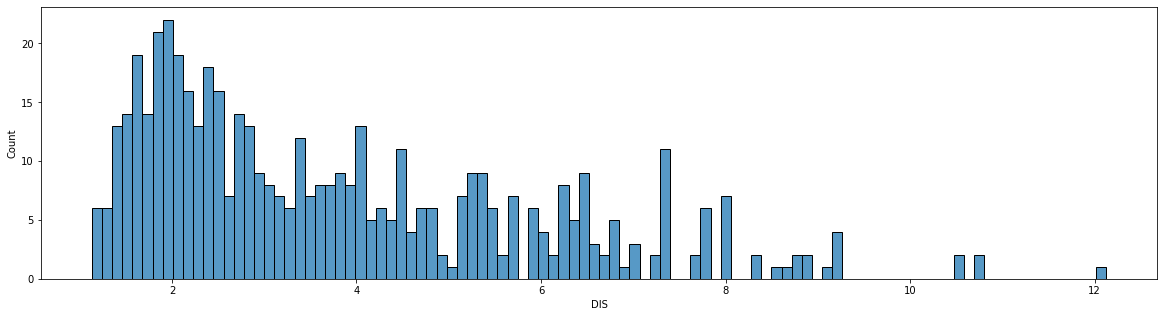

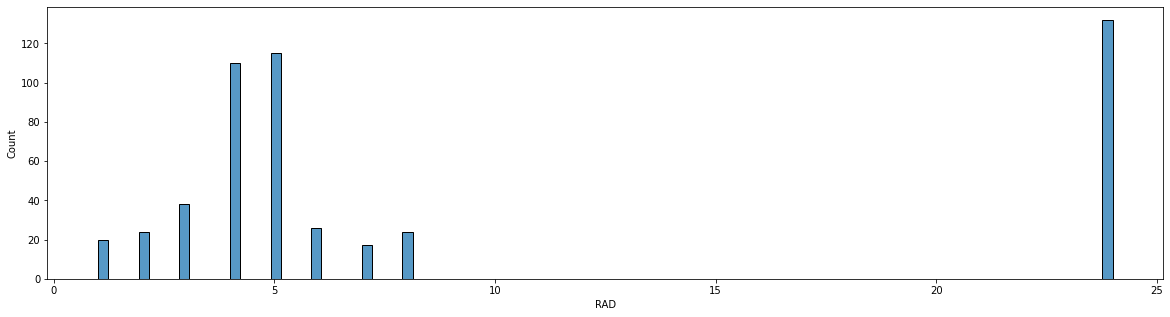

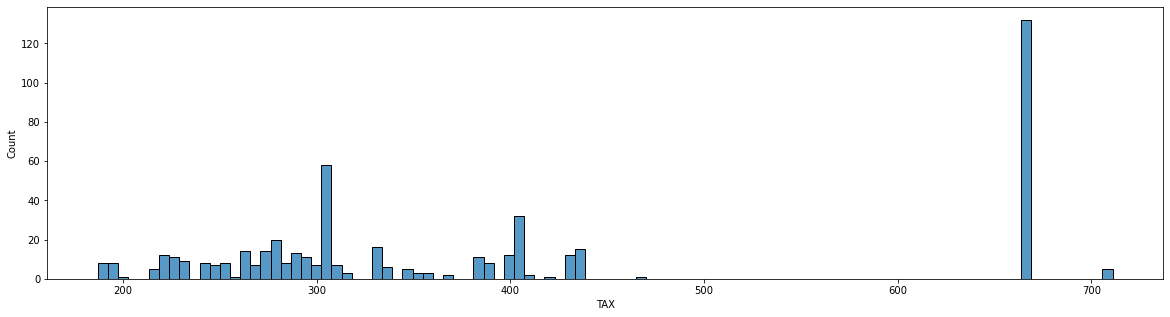

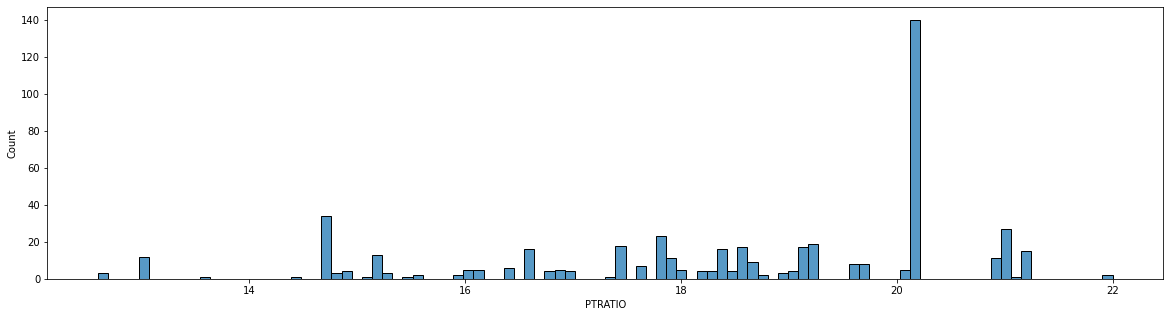

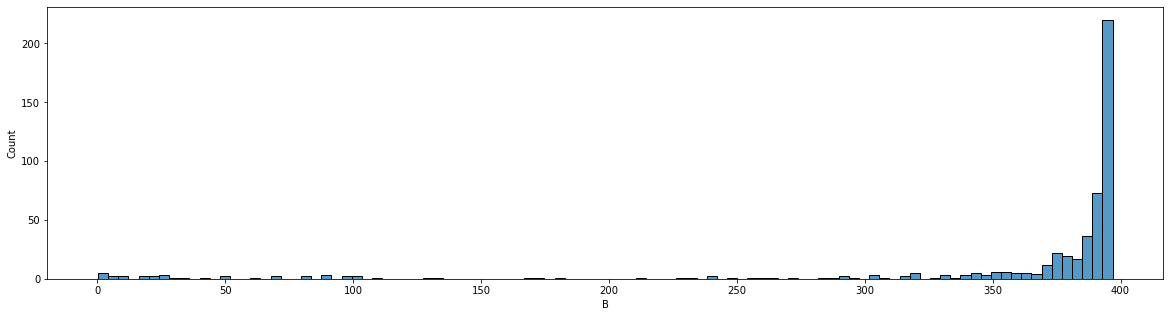

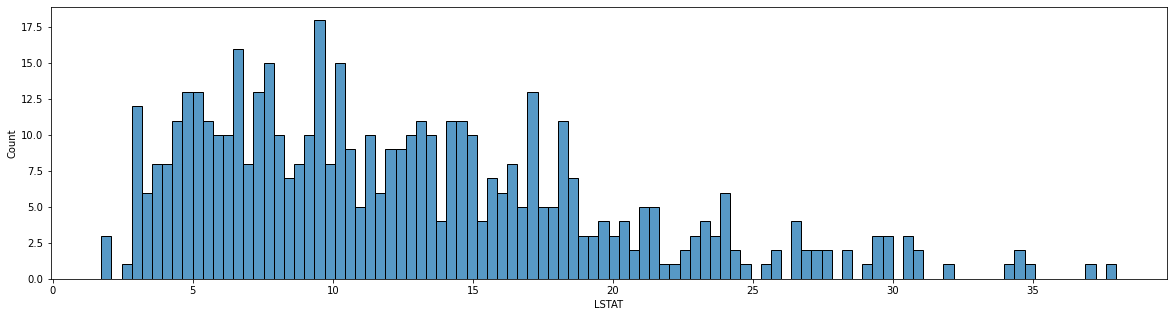

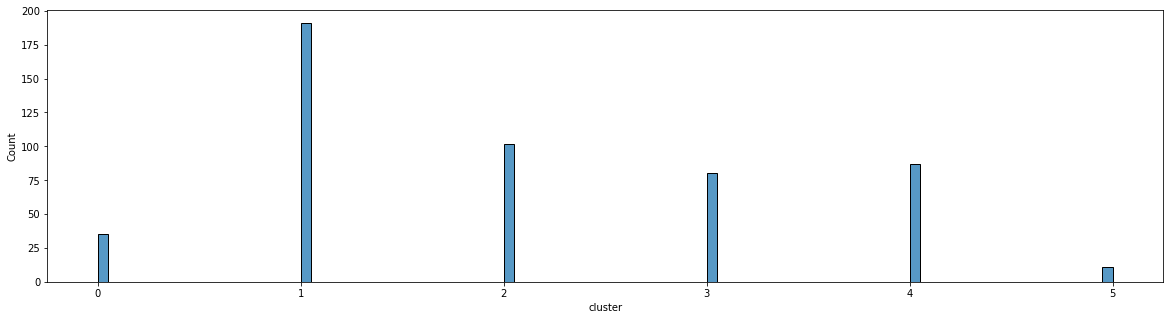

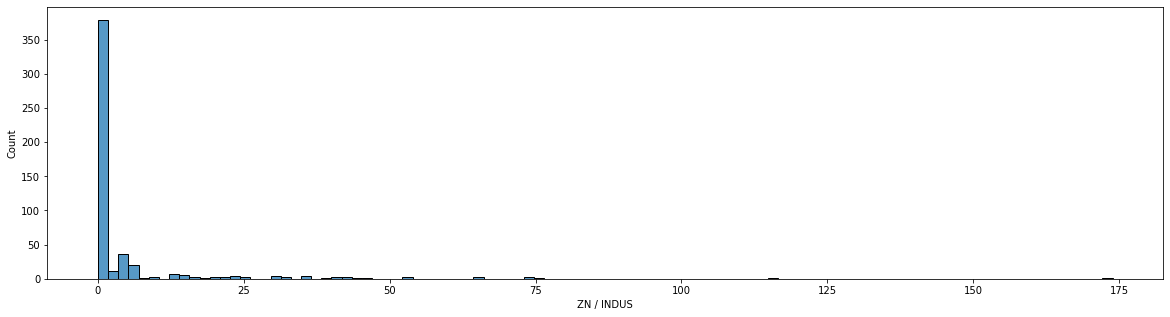

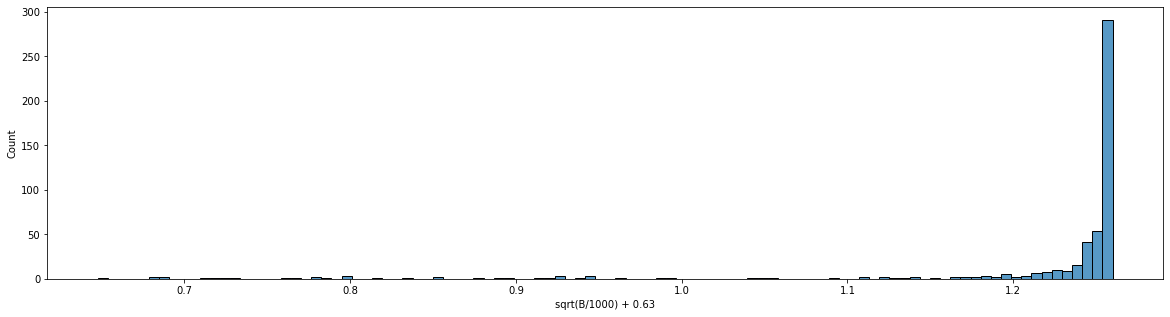

In [11]:
for column in data.columns:
    plt.figure()
    sns.histplot(data[column], bins=100)

Видим несколько возможных индикаторов:
* INDUS -процент производства, индикатор > 15
* ZN -процент жилых зон, индикаторы 0, > 70
* NOX - процент оксида азота, индикатор > 0.8
* RAD - индекс доступности железных дорог, индикатор > 20
* TAX - налог на недвижимость, индикатор > 600
* MEDV - помимо нормального распределения, есть отдельная категория "дорогого" жилья. Проверим, сможем ли мы научить отдельную модель предсказывать индикатор этой категории

In [12]:
initial_score = get_score(data, target)

df = data.copy()
df['INDUS > 15'] = np.where(df['INDUS'] > 15, 1, 0 )
print('INDUS > 15', get_score( df, target) - initial_score)

df = data.copy()
df['ZN == 0'] = np.where(df['ZN'] == 0, 1, 0 )
print('ZN == 0', get_score( df, target) - initial_score)

df = data.copy()
df['ZN > 70'] = np.where( df['ZN'] > 70, 1, 0 )
print('ZN > 70', get_score(df, target) - initial_score)

df = data.copy()
df['NOX > 0.8'] = np.where( df['NOX'] > 0.8, 1, 0 )
print('NOX > 0.8', get_score(df, target) - initial_score)

df = data.copy()
df['RAD > 20'] = np.where( df['RAD'] > 20, 1, 0 )
print('RAD > 20', get_score(df, target) - initial_score)

df = data.copy()
df['TAX > 600'] = np.where( df['TAX'] > 600, 1, 0 )
print('TAX > 600', get_score(df, target) - initial_score)

df = data.copy()
df['MEDV == 50'] = np.where( target == 50, 1, 0 )
print('MEDV == 50', get_score(df, target) - initial_score)

INDUS > 15 0.0008880837245701656
ZN == 0 -0.0013456961817169821
ZN > 70 -0.0006687924840700354
NOX > 0.8 -0.0006228660258164043
RAD > 20 -0.0007160855568930646
TAX > 600 -0.0007174568859538155
MEDV == 50 0.08568754806748013


Из индикаторов полезен только INDUS > 15

In [13]:
data['INDUS > 15'] = np.where( data['INDUS'] > 15, 1, 0)

А вот обучение отдельной модели для предсказания "особо дорогого жилья" выглядит перспективно

In [14]:
df = data.copy()
medv_target = np.where( target == 50, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(df, medv_target, test_size=0.3, random_state=42) 
model = LogisticRegression().fit(X_train, y_train)
model.score(X_test, y_test)

0.9802631578947368

Модель работает очень хорошо, проверим, повлияет ли это на основную модель

In [15]:
initial_score = get_score(data, target)

df = data.copy()
df['MEDV == 50'] = model.predict(df)
print('MEDV == 50', get_score(df, target) - initial_score)

MEDV == 50 0.04324644178258852


Создание дополнительной модели предсказания дорогой недвижимости однозначно оправдалось

In [16]:
data['MEDV == 50'] = model.predict(data)

### Нормализуем данные

In [17]:
initial_score = get_score(data, target)

df = Normalizer().fit_transform(data)
print('Normalizer', get_score(df, target) - initial_score)

Normalizer -0.0062833752357772665


Нормализация пользы не принесла, не используем ее

### Удаляем переменные:

Проверяем для каждой переменной, улучшает ли качество модели ее удаление

In [18]:
initial_score = get_score(data, target)

for column in list(data.columns):
    df = data.copy()
    del df[column]
    print(column, get_score(df, target) - initial_score)

CRIM -0.0017103477827061786
ZN -0.0006554422131976878
INDUS -0.0005138799058003185
CHAS -0.000494693310071681
NOX -0.0165349484071472
RM -0.030422461532840672
AGE 0.00158502953808215
DIS -0.025672179989690735
RAD -0.007048669401947705
TAX -0.0076909905767863496
PTRATIO -0.013928170511036009
B -0.00029542274208382846
LSTAT -0.04342812010669206
cluster 2.0096347450038188e-05
ZN / INDUS 0.002749879748557227
sqrt(B/1000) + 0.63 -0.00101265707115894
INDUS > 15 -0.000860045769675355
MEDV == 50 -0.04324644178258852


Удаление переменных INDUS, ZN / INDUS дает улучшение, пусть и незначительное

In [19]:
del data['INDUS']
del data['ZN / INDUS']

### Проверяем результат работы:

In [20]:
print(get_score(data, target) / start_score)

1.0742343390778109


После всех манипуляций нам удалось повысить коэффициент детерминации модели больше, чем на 7 процентов